In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from othello.OthelloGame import OthelloGame as Game
from othello.OthelloGame import display as displayGame

import numpy as np

In [3]:
from othello_viz import display_board, plot_episode

In [4]:
def display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces):
    print('player_1 wins:', str(int(100*player_1_wins/episodes + 0.5)) + '%')
    print('player_2 wins:', str(int(100*player_2_wins/episodes + 0.5)) +'%')
    print('ties:', str(int(100*ties/episodes + 0.5))+ '%')
    print('Max, Mean, Min margins: ', end ='')
    print(np.max(margins), np.mean(margins), np.min(margins))
    print('Max, Mean, Min steps: ', end ='')
    print(np.max(steps_array), np.mean(steps_array), np.min(steps_array))
    print('Max, Mean, Min pieces: ', end ='')
    print(np.max(pieces), np.mean(pieces), np.min(pieces))

In [162]:
def play_with_model(model, game, board,  exploit = False, epsilon=1e-12, conv=False, return_predictions=False):
    if conv:
        predictions = model.predict(board.reshape(-1, 4, 4, 1))
    else:
        predictions = model.predict(board.reshape(1,-1))
    valid_moves = game.getValidMoves(board, 1)
    predictions_ = predictions[0].copy()
    if valid_moves[-1] == 1:
        if return_predictions:
            return 16, predictions_
        else:
            return 16
    predictions = (predictions + epsilon) * valid_moves[:-1] 
    #print(predictions)
    predictions = predictions/predictions.sum()
    if exploit:
        action = np.argmax(predictions)
    else:
        action = np.random.choice(16, p=predictions[0])
    if return_predictions:
        return action, predictions_
    else:
        return action

In [355]:
def play_episode(players, game, board, return_actions=False, append_last=False, return_predictions=False):
    # No necesita el jugador que comienza por que se resuelve en su forma canonica. 
    # Se ve el juego en la perspectiva de blanco siempre
    # board = game.getCanonicalForm(board, 1)
    states = []
    actions = []
    rewards = []
    predictions = []
    player_turn = 0
    ended = game.getGameEnded(board, 1) 
    while ended == 0:
        states.append(board)
        if return_predictions:
            action, prediction = players[player_turn](game, board, return_predictions=True)
            predictions.append(prediction)
        else:
            action = players[player_turn](game, board)
        actions.append(action)
        board, _ = game.getNextState(board, 1, action)
        board = game.getCanonicalForm(board, -1)
        player_turn = (player_turn + 1) % len(players)
        ended = game.getGameEnded(board, 1) 
        if ended==0:
            rewards.append(0)
        else:
            rewards.append(-np.sign(board.sum()))
    if append_last:
        states.append(board)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    if return_actions and return_predictions:
        predictions = np.array(predictions)
        return states, actions, rewards, predictions
    elif return_actions:
        return states, actions, rewards
    else:
        return states

In [169]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards, predictions = play_episode([lambda game, board, return_predictions: play_with_model(model, game, board, conv=True, return_predictions=return_predictions), 
                                         lambda game, board, return_predictions: play_with_model(model, game, board, conv=True, return_predictions=return_predictions)], 
                                        game, board*player, return_actions=True, return_predictions=True)
print('longitud episodio:', len(states))

longitud episodio: 10


In [429]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Concatenate, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy, binary_crossentropy

def get_policy_model_softmax(lr=0.001, hidden_layer_neurons = 256, input_shape=[16], output_shape=16):
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

def get_policy_model_softmax_cnn(lr=0.001, filters = 16, filter_size=3, input_shape=[4, 4, 1], output_shape=16):
    model = Sequential()
    model.add(Conv2D(filters, filter_size, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

In [440]:
def get_policy_model_softmax_cnn_deep(lr=0.001, input_shape=[4, 4, 1], output_shape=16):
    model = Sequential()
    model.add(Conv2D(16, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

def get_value_model_cnn_deep(lr=0.001, input_shape=[4, 4, 1], output_shape=1):
    model = Sequential()
    model.add(Conv2D(16, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 2, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(output_shape))
    model.compile(Adam(lr), loss=['mse'])
    return model

In [281]:
def get_policy_concat_cnns(lr=0.001, filters = 128, input_shape=[4, 4, 1], output_shape=16):
    x = Input(shape=input_shape)
    x1 = Flatten()(Conv2D(filters, 2, activation='relu')(x))
    x2 = Flatten()(Conv2D(filters, 3, activation='relu')(x))
    x3 = Flatten()(Conv2D(filters, 4, activation='relu')(x))
    concat = Concatenate()([x1, x2, x3])
    out = Dense(output_shape, activation='softmax')(concat)
    model = Model(x, out)
    model.compile(Adam(lr), loss=['categorical_crossentropy'])
    return model

In [283]:
model = get_policy_concat_cnns()

In [284]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 4, 4, 1)      0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 3, 3, 128)    640         input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 2, 2, 128)    1280        input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 1, 1, 128)    2176        input_22[0][0]                   
____________________________________________________________________________________________

In [113]:
get_policy_model_softmax_cnn_deep().summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 3, 16)          80        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 32)          2080      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 64)          8256      
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
Total params: 11,456
Trainable params: 11,456
Non-trainable params: 0
_________________________________________________________________


In [114]:
model = get_policy_model_softmax_cnn(filters = 32)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 2, 2, 32)          320       
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                2064      
Total params: 2,384
Trainable params: 2,384
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Defino juego
n = 4
game = Game(n)
board = game.getInitBoard()

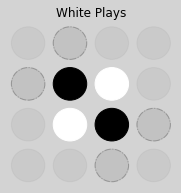

In [116]:
player = 1
display_board(game, board, player, valid_moves=game.getValidMoves(board, player))

In [117]:
def random_player(game, board):
    valid_modes = game.getValidMoves(board, 1)
    valid_moves_idxs = np.where(valid_modes == 1)[0]
    action = np.random.choice(valid_moves_idxs)
    return action

In [118]:
random_player(game, board)

1

In [119]:
model = get_policy_model_softmax_cnn()
# model = get_policy_model_softmax()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 2, 2, 16)          160       
_________________________________________________________________
flatten_18 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                1040      
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [148]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards, predictions = play_episode([lambda game, board, return_predictions: play_with_model(model, game, board, conv=True, return_predictions=return_predictions), 
                                         lambda game, board, return_predictions: play_with_model(model, game, board, conv=True, return_predictions=return_predictions)], 
                                        game, board*player, return_actions=True, return_predictions=True)
print('longitud episodio:', len(states))

longitud episodio: 12


In [149]:
predictions

array([[0.05563404, 0.06311154, 0.06805106, 0.05864551, 0.0730752 ,
        0.06161088, 0.07056948, 0.05442092, 0.06276173, 0.05991254,
        0.06769767, 0.05847799, 0.05794302, 0.06420163, 0.06517696,
        0.05870979]], dtype=float32)

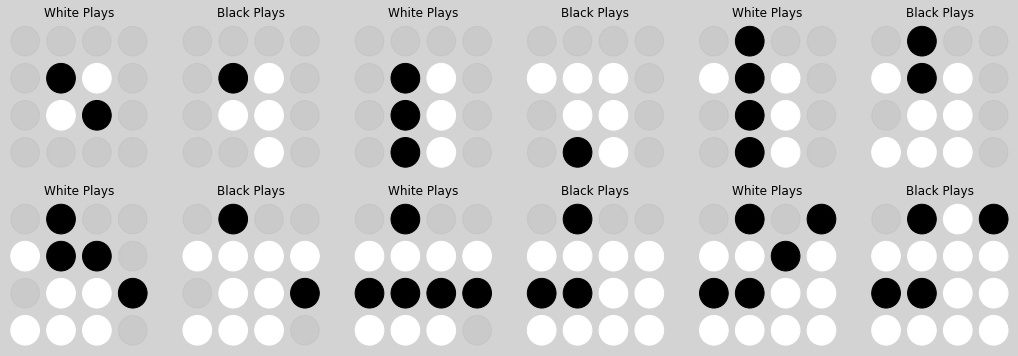

In [125]:
# Grafico episodio
plot_episode(game, states, initial_player = player)

In [339]:
def get_acc_rew(rewards, gamma=0.99):
    accumulated_rewards = []
    rew = rewards[-1]
    accumulated_rewards.append(rew)
    for i in range(len(rewards)-1):
        rew = rew*-gamma
        accumulated_rewards.append(rew)
    accumulated_rewards=np.array(accumulated_rewards)[::-1]
    return accumulated_rewards

In [340]:
get_acc_rew(rewards)

array([-0.87752102,  0.88638487, -0.89533825,  0.90438208, -0.91351725,
        0.92274469, -0.93206535,  0.94148015, -0.95099005,  0.96059601,
       -0.970299  ,  0.9801    , -0.99      ,  1.        ])

juega w con tablero: [ 0  0  0  0  0 -1  1  0  0  1 -1  0  0  0  0  0] dada accion: 1 se evalua: -0.8775210229989678, 0
juega b con tablero: [ 0 -1  0  0  0 -1 -1  0  0 -1  1  0  0  0  0  0] dada accion: 0 se evalua: 0.8863848717161291, 0
juega w con tablero: [-1  1  0  0  0 -1  1  0  0  1 -1  0  0  0  0  0] dada accion: 11 se evalua: -0.8953382542587163, 0
juega b con tablero: [ 1 -1  0  0  0  1 -1  0  0 -1 -1 -1  0  0  0  0] dada accion: 15 se evalua: 0.9043820750088043, 0
juega w con tablero: [-1  1  0  0  0 -1  1  0  0  1 -1  1  0  0  0 -1] dada accion: 14 se evalua: -0.9135172474836407, 0
juega b con tablero: [ 1 -1  0  0  0  1 -1  0  0 -1 -1 -1  0  0 -1  1] dada accion: 13 se evalua: 0.92274469442792, 0
juega w con tablero: [-1  1  0  0  0 -1  1  0  0 -1  1  1  0 -1 -1 -1] dada accion: 8 se evalua: -0.9320653479069899, 0
juega b con tablero: [ 1 -1  0  0  0  1 -1  0 -1 -1 -1 -1  0  1  1  1] dada accion: 2 se evalua: 0.9414801494009999, 0
juega w con tablero: [-1 -1 -1  0  0 -1 -1

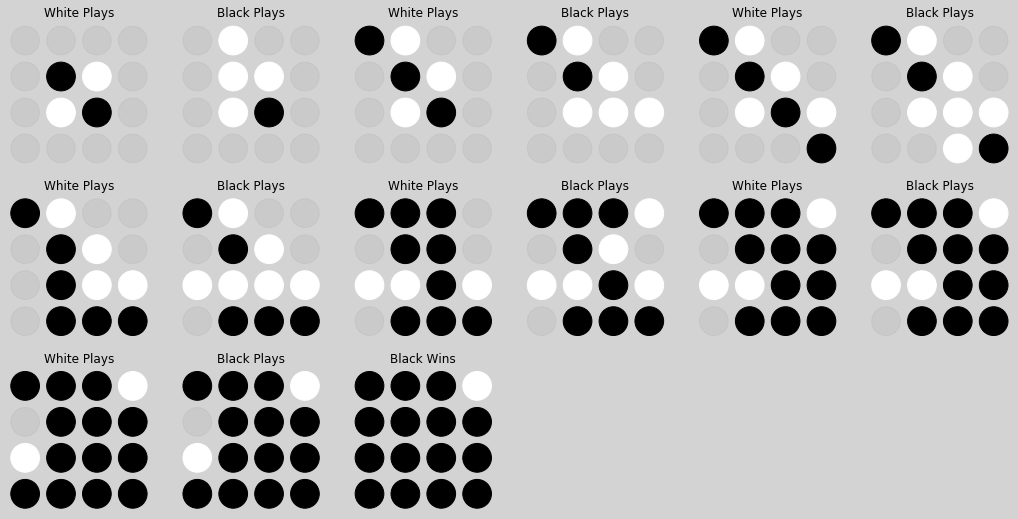

In [341]:
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards = play_episode([lambda game, board: play_with_model(model, game, board, conv=True), 
                                         lambda game, board: play_with_model(model, game, board, conv=True)], game, board*player, return_actions=True, 
                                        append_last=True
                                       )
plot_episode(game, states, initial_player = player)
accumulated_rewards = get_acc_rew(rewards)
states_fl = np.array(states).reshape(-1, 16)
for i in range(len(rewards)):
    turn = ['w', 'b'][i%2]
    print(f'juega {turn} con tablero: {states_fl[i]} dada accion: {actions[i]} se evalua: {accumulated_rewards[i]}, {rewards[i]}')

In [128]:
states.shape, actions.shape, accumulated_rewards.shape

((15, 4, 4), (14,), (14,))

In [129]:
accumulated_rewards

array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1])

# Evaluate

In [130]:
from playing_stats import EvaluatePolicy
optimum_policy = np.load('pi_func_only_winner.npy', allow_pickle=True).item()
optimum_V = np.load('Value_func_only_winner.npy', allow_pickle=True).item()
evalPolicy = EvaluatePolicy(optimum_policy)

In [464]:
def evaluate_training(model, episodes = 100, conv=False):
    player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                    board, 
                                                    {1: evalPolicy.random_player, -1: lambda game, board: play_with_model(model, game, board, conv=conv)}, 
                                                    episodes)
    porc = 100.0*player_2_wins/episodes
    print(f'El modelo gana el {porc}% de las veces jugando segundo')
    # display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

In [137]:
evaluate_training(model, conv=True)

El modelo gana el 58% de las veces jugando segundo. El segundo debería ganar el 100%


In [138]:
# model = get_policy_model_softmax()
model = get_policy_model_softmax_cnn()
evaluate_training(model, episodes = 1000, conv=True)

El modelo gana el 56% de las veces jugando segundo. El segundo debería ganar el 100%


# Train

In [139]:
from keras.utils import to_categorical

In [441]:
model = get_policy_model_softmax_cnn_deep(lr=0.001,)
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 3, 3, 16)          80        
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
activation_8 (Activation)    (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 2, 2, 32)          2080      
_________________________________________________________________
batch_normalization_9 (Batch (None, 2, 2, 32)          128       
_________________________________________________________________
activation_9 (Activation)    (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 1, 1, 64)        

In [444]:
model_v = get_value_model_cnn_deep(lr=0.001)
model_v.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 3, 3, 16)          80        
_________________________________________________________________
batch_normalization_17 (Batc (None, 3, 3, 16)          64        
_________________________________________________________________
activation_17 (Activation)   (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 2, 2, 32)          2080      
_________________________________________________________________
batch_normalization_18 (Batc (None, 2, 2, 32)          128       
_________________________________________________________________
activation_18 (Activation)   (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 1, 1, 64)        

In [437]:
def play_episodes(model, episodes=1, conv=True):
    states_ = []
    actions_ = []
    rewards_ = []
    predictions_ = []
    for i in range(episodes):
        states, actions, rewards, predictions = play_episode([lambda game, board, return_predictions: 
                                                              play_with_model(model, game, board, conv=conv, return_predictions=return_predictions), 
                                             lambda game, board, return_predictions: 
                                                              play_with_model(model, game, board, conv=conv, return_predictions=return_predictions)], 
                                            game, board*player, return_actions=True, return_predictions=True)
        states_.append(states)
        actions_.append(actions.reshape(-1, 1))
        rewards_.append(rewards.reshape(-1, 1))
        predictions_.append(predictions)
    return np.vstack(states_), np.vstack(actions_), np.vstack(rewards_), np.vstack(predictions_)

In [ ]:
# model = get_policy_model_softmax(lr=0.001, hidden_layer_neurons=1024)
# model = get_policy_model_softmax_cnn(lr=0.001, filters=1024, filter_size=4)
model = get_policy_model_softmax_cnn_deep(lr=0.001)
model_v = get_value_model_cnn_deep(lr=0.001)
# model = get_policy_concat_cnns(lr=0.0001)
# model.compile(Adam(lr=0.0001), loss='categorical_crossentropy')
epsilon = 1e-12
losses = []
mse_losses = []
episodes = 1000
player = 1
eval_period = 200
if type(model.layers[0]) == Dense:
    conv=False
else:
    conv=True
for episode in range(episodes):       
#     states, actions, rewards, predictions = play_episode([lambda game, board, return_predictions: 
#                                                           play_with_model(model, game, board, conv=conv, return_predictions=return_predictions), 
#                                          lambda game, board, return_predictions: 
#                                                           play_with_model(model, game, board, conv=conv, return_predictions=return_predictions)], 
#                                         game, board*player, return_actions=True, return_predictions=True)
    
    states, actions, rewards, predictions = play_episodes(model, episodes=3, conv=conv)
    accumulated_rewards = get_acc_rew(rewards)
    no_move_indexes = (actions != 16).flatten()
    states = states[no_move_indexes]
    actions = actions[no_move_indexes].reshape(-1, 1)
    accumulated_rewards = accumulated_rewards[no_move_indexes].reshape(-1, 1)
    
    
# Augmentation
    states = np.vstack([states, np.flip(states, axis=[2]), np.flip(states, axis=[1]), np.rot90(states, axes=(1, 2))])
    actions = np.vstack([actions, actions, actions, actions])
    accumulated_rewards = np.vstack([accumulated_rewards, accumulated_rewards, accumulated_rewards, accumulated_rewards])
    
    if conv:
        x_train = states.reshape(-1, 4, 4, 1)
    else:
        x_train = states.reshape(-1, 16)
    
    hist = model_v.fit(x_train, accumulated_rewards, epochs=1, verbose=0, batch_size=len(states))
    mse_loss = hist.history['loss'][0]
    accumulated_rewards_preds = model_v.predict(x_train, verbose=0)
    mse_losses.append(hist.history['loss'][-1])
    
    y_train = to_categorical(actions, 16)*(accumulated_rewards - accumulated_rewards_preds)
    hist = model.fit(x_train, y_train, verbose=0, batch_size=len(states))
    loss = hist.history['loss'][-1]
    losses.append(loss)
    if episode%eval_period == 0:
        entropy = np.mean(-np.sum(np.log(predictions+epsilon)*predictions, axis=1)/np.log(16))
        print(f'episode: {episode}, entropy={entropy}, loss={np.mean(losses[-eval_period:])}, mse_loss={np.mean(mse_losses[-eval_period:])}')
        evaluate_training(model, episodes=500, conv=conv)
evaluate_training(model, episodes=1000, conv=conv)

episode: 0, entropy=0.9991528987884521, loss=0.028101077303290367, mse_loss=1.3924992084503174
El modelo gana el 40.4% de las veces jugando segundo
episode: 200, entropy=0.597474217414856, loss=-0.28166263225954025, mse_loss=0.6901590442284942
El modelo gana el 82.6% de las veces jugando segundo
episode: 400, entropy=0.32916927337646484, loss=-0.3983043508697301, mse_loss=0.6000002263486386
El modelo gana el 92.0% de las veces jugando segundo
episode: 600, entropy=0.322980135679245, loss=-0.4343891587085091, mse_loss=0.5166582495346665
El modelo gana el 96.4% de las veces jugando segundo
episode: 800, entropy=0.18240773677825928, loss=-0.8538885075831786, mse_loss=0.48890755567699673
El modelo gana el 96.4% de las veces jugando segundo


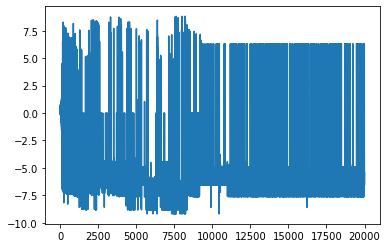

In [363]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [289]:
from playing_stats import EvaluatePolicy
optimum_policy = np.load('pi_func_only_winner.npy', allow_pickle=True).item()
optimum_V = np.load('Value_func_only_winner.npy', allow_pickle=True).item()
evalPolicy = EvaluatePolicy(optimum_policy)

In [290]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.policy_player, -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 84%
player_2 wins: 16%
ties: 0%
Max, Mean, Min margins: 14 3.44 -9
Max, Mean, Min steps: 14 11.7 9
Max, Mean, Min pieces: 16 15.216 12


In [292]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.policy_player, -1: lambda game, board: play_with_model(model, game, board, conv=conv)}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 0%
player_2 wins: 100%
ties: 0%
Max, Mean, Min margins: 2 -5.988 -6
Max, Mean, Min steps: 14 12.77 12
Max, Mean, Min pieces: 16 16.0 16


In [293]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: lambda game, board: play_with_model(model, game, board, conv=conv, exploit=True)}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 2%
player_2 wins: 98%
ties: 0%
Max, Mean, Min margins: 8 -8.251 -16
Max, Mean, Min steps: 14 9.449 8
Max, Mean, Min pieces: 16 12.509 11


In [295]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 100
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: lambda game, board: play_with_model(model, game, board, conv=conv), -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 53%
player_2 wins: 36%
ties: 11%
Max, Mean, Min margins: 16 1.71 -14
Max, Mean, Min steps: 15 12.29 7
Max, Mean, Min pieces: 16 15.57 10


In [297]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 100
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: lambda game, board: play_with_model(model, game, board, conv=conv) , -1: evalPolicy.policy_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 0%
player_2 wins: 100%
ties: 0%
Max, Mean, Min margins: -2 -5.46 -16
Max, Mean, Min steps: 14 12.77 12
Max, Mean, Min pieces: 16 15.98 15
